In [1]:
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [2]:
def scatter_plot_data(X,y, class_names, feature_names,marker='o',colors=[]):
    classes = np.unique(y)
    for i,class_ in enumerate(classes):
        X_class = X[np.where(y==class_)[0],:]
        if len(colors)==0:
            plt.scatter(X_class[:,0], X_class[:,1], marker=marker)
        else:
            plt.scatter(X_class[:,0], X_class[:,1], marker=marker,color = colors[i])
    plt.legend(class_names, loc=4)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])


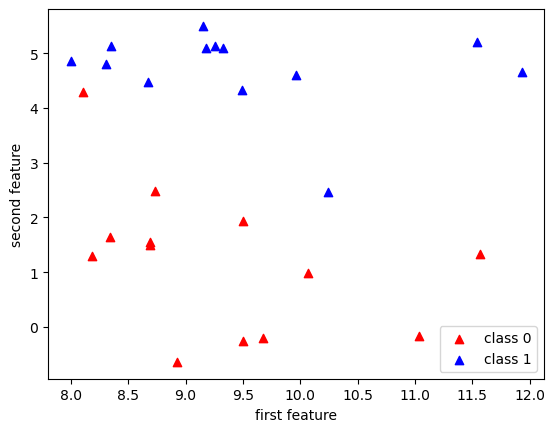

In [3]:
# generate dataset
X, y = mglearn.datasets.make_forge()
# plot dataset
scatter_plot_data(X,y,['class 0','class 1'],['first feature', 'second feature'],'^',colors=['red', 'blue'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=20)
print(f"Train data shape = {X_train.shape}")
print(f"Test data shape = {X_test.shape}")

Train data shape = (20, 2)
Test data shape = (6, 2)


In [173]:
import matplotlib.pyplot as plt

def plot_tree(node, depth=0, parent_pos=None, node_pos={}, depth_pos={}, ax=None, feature_names = {}):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.invert_yaxis()  # Invert y-axis to have the root at the top

    if depth not in depth_pos:
        depth_pos[depth] = 0
    else:
        depth_pos[depth] += 1

    node_x = depth_pos[depth]
    node_y = depth
    node_pos[node] = (node_x, node_y)

    if parent_pos is not None:
        # Draw line from parent to current node
        plt.plot([parent_pos[0], node_x], [parent_pos[1], node_y], 'k-')

    if node.feature is not None:
        # This is an internal node
#         print(f"type = {type(node.val)}, val = {node.val}, feature_names = {feature_names[node.val]}")
        label = f"X[{node.feature}] <= {node.thresh:.2f}\nGini={node.gini_impurity:.2f}\nmax_class={feature_names[node.val]}\nSamples={node.samples}\n"
    else:
        # This is a leaf node
#         print(f"type = {type(node.val)}, val = {node.val}")
#         print(f"feature_names = {feature_names[node.val]}")
        label = f"Class={node.val}\nSamples={node.samples}\nGini={node.gini_impurity:.2f}\nmax_class={feature_names[node.val]}"

    ax.text(node_x, node_y, label, horizontalalignment='center')

    if node.left is not None:
        plot_tree(node.left, depth + 1, (node_x, node_y), node_pos, depth_pos, ax=ax, feature_names = feature_names)

    if node.right is not None:
        plot_tree(node.right, depth + 1, (node_x, node_y), node_pos, depth_pos, ax=ax, feature_names = feature_names)

    if depth == 0:
        plt.axis('off')
        plt.show()

# Assuming `tree_` is your fitted DecisionTreeClassifier instance's root node
# plot_tree(tree_.tree_)


In [174]:
class TreeNode:
    def __init__(self, y, gini, samples, feature, thresh, left = None, right = None):
        self.feature = feature
        self.thresh = thresh
        self.left = left
        self.right = right
        self.gini_impurity = gini
        self.samples = samples
        classes = np.unique(y)
        self.val = int(np.argmax(np.bincount(y)))

In [175]:
class DecisionTreeClassifier:
    def __init__(self, max_leaf_nodes=1, min_samples_split=1, min_samples_leaf=1, gini_thresh = 0.01, max_depth=3):
        self.max_leaf_nodes = max_leaf_nodes
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.gini_thresh = gini_thresh
        self.max_depth = max_depth
        self.tree_ = None
    def compute_gini_impurity(self, y):
        p = 0
        for class_ in self.classes:
            p_i_k = y[y==class_].shape[0]/y.shape[0]
            p+=(p_i_k)**2
        gini_impurity = 1-p
        return gini_impurity
    def compute_split(self, X, y, depth):

        m, num_features = X.shape
        #calculate gini
        gini = self.compute_gini_impurity(y)
        depth = depth+1
        
        #terminating condition, if num leaf nodes are within a thresh or gini is within a thresh
        if m<self.min_samples_split or gini<self.gini_thresh or depth>=self.max_depth:
            print(f"{self.min_samples_split}, gini = {gini}, depth = {depth}")
            leaf_node = TreeNode(y,gini,m,None,None)
            return leaf_node
        
        #some variables for tracking
        min_gini = math.inf
        t_k = None 
        k = None
        samples = 0
        X_left_post, y_left_post, X_right_post, y_right_post = None, None, None, None
        
        #check for each feature, split at each value and calculate gini. Get thresh and feature for min total gini
        for feat in range(num_features):
            split_thresh = np.unique(X[:,feat])
            for thresh in split_thresh:
                #get left and right candidate splits
                left_mask = X[:,feat]<=thresh
                X_left, y_left  = X[left_mask], y[left_mask]
                right_mask = X[:,feat]>thresh
                X_right, y_right = X[right_mask], y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue

                gini_left = self.compute_gini_impurity(y_left)
                gini_right = self.compute_gini_impurity(y_right)
                m_left = y_left.shape[0]
                m_right = y_right.shape[0]
                gini = (m_left/m)*gini_left+(m_right/m)*gini_right
                if gini<min_gini:
                    min_gini = gini
                    t_k = thresh
                    k = feat
                    samples = m
                    X_left_post, y_left_post = X_left, y_left
                    X_right_post, y_right_post = X_right, y_right 
        
        if min_gini == math.inf or min_gini < self.gini_thresh:
            print(f"min_gini = {min_gini}")
            return TreeNode(y, self.compute_gini_impurity(y), m, None, None)

        print(f"best split at {min_gini}, t_k = {t_k}, k = {k}, samples = {m}")
        #create node in decision tree based on split
        node = TreeNode(y,min_gini, m, k, t_k)
        #recusrively call left and right tree
        node.left = self.compute_split(X_left_post, y_left_post, depth)
        node.right = self.compute_split(X_right_post, y_right_post, depth)
        return node
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.tree_ = self.compute_split(X,y,0)

In [176]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [177]:
iris_class_dict = {}
for i,class_name in enumerate(iris['target_names']):
    iris_class_dict[i] = class_name
iris_class_dict

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [178]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X, y)

best split at 0.3333333333333333, t_k = 1.9, k = 2, samples = 150
1, gini = 0.0, depth = 2
best split at 0.11030595813204513, t_k = 1.7, k = 3, samples = 100
1, gini = 0.16803840877914955, depth = 3
1, gini = 0.04253308128544431, depth = 3


In [179]:
iris_class_dict[0]

'setosa'

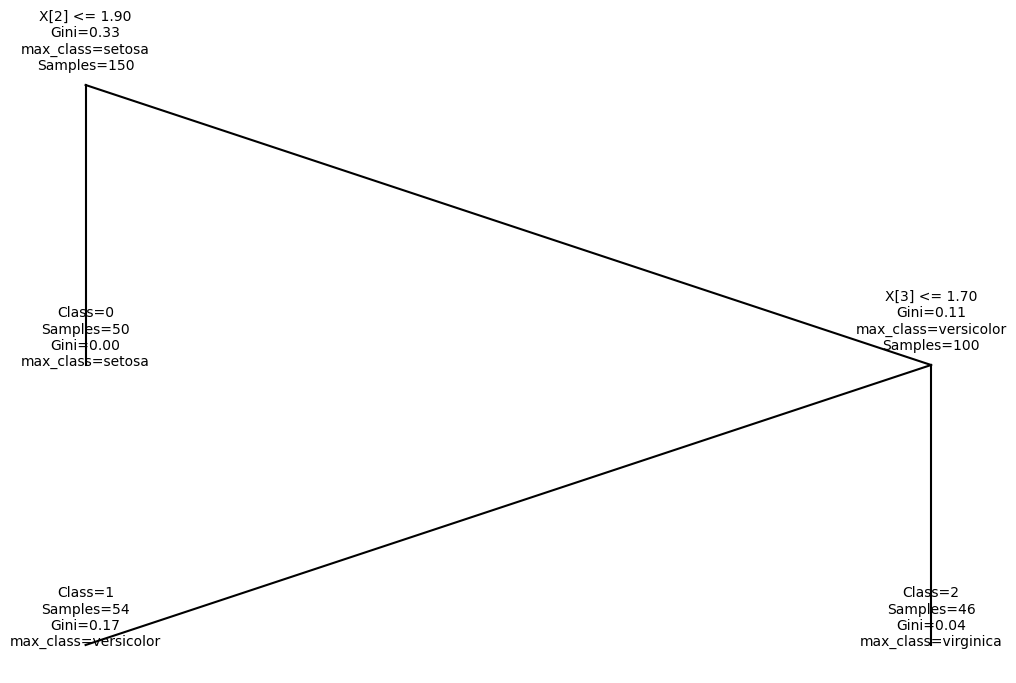

In [180]:
plot_tree(tree.tree_, feature_names = iris_class_dict)

In [59]:
decision_tree_cls = DecisionTreeClassifier()
decision_tree_cls.fit(X_train,y_train)
decision_tree_cls.tree_.__dict__

best split at 0.333125, t_k = 1.9, k = 2, samples = 120
1, gini = 0.0, depth = 2
best split at 0.13478944060339404, t_k = 4.7, k = 2, samples = 80
1, gini = 0.0525931336742147, depth = 3
1, gini = 0.2055164954029205, depth = 3


{'feature': 2,
 'thresh': 1.9,
 'left': <__main__.TreeNode at 0x7fc4e28e5010>,
 'right': <__main__.TreeNode at 0x7fc3a9dc1f90>,
 'gini_impurity': 0.333125,
 'samples': 120,
 'val': 1}

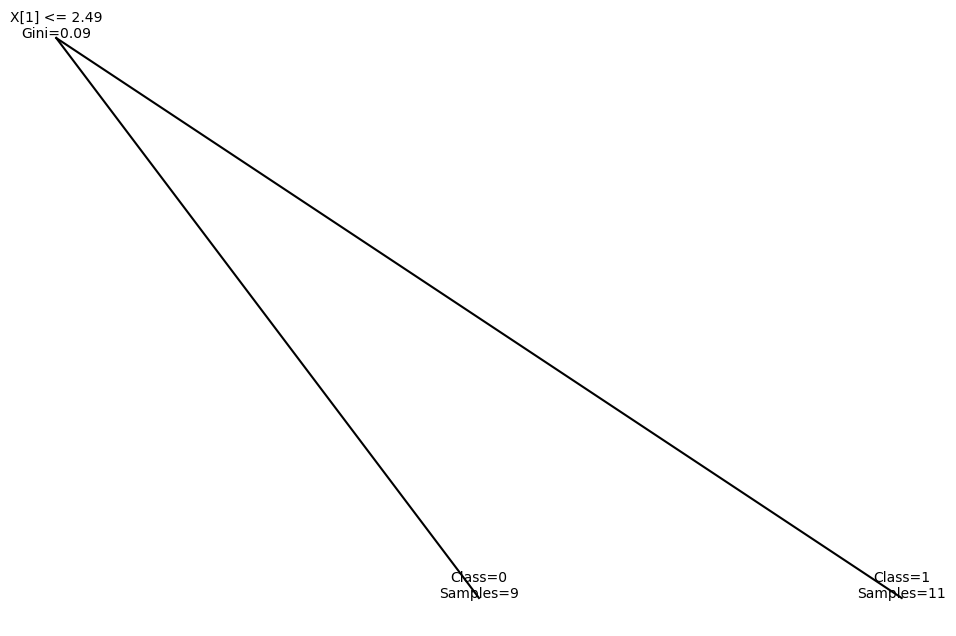

In [52]:
print(decision_tree_cls.tree_)

In [11]:
test_node = node(val=np.array([1,50,45]))
decision_tree_cls.compute_gini_impurity(test_node)

p_i_k = [1.08506944e-04 2.71267361e-01 2.19726562e-01], gini_impurity = 0.5088975694444444


In [16]:
(45/(1+50+45))**2

0.2197265625

In [17]:
help(np.where)

Help on function where in module numpy:

where(...)
    where(condition, [x, y], /)
    
    Return elements chosen from `x` or `y` depending on `condition`.
    
    .. note::
        When only `condition` is provided, this function is a shorthand for
        ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
        preferred, as it behaves correctly for subclasses. The rest of this
        documentation covers only the case where all three arguments are
        provided.
    
    Parameters
    ----------
    condition : array_like, bool
        Where True, yield `x`, otherwise yield `y`.
    x, y : array_like
        Values from which to choose. `x`, `y` and `condition` need to be
        broadcastable to some shape.
    
    Returns
    -------
    out : ndarray
        An array with elements from `x` where `condition` is True, and elements
        from `y` elsewhere.
    
    See Also
    --------
    choose
    nonzero : The function that is called when x an